


58889256/58889256 [==============================] - 12s 0us/step
Epoch 1/50


11/11 [==============================] - 105s 9s/step - loss: 0.5403 - accuracy: 0.7558 - val_loss: 0.6297 - val_accuracy: 0.6512
Epoch 2/50
11/11 [==============================] - 95s 9s/step - loss: 0.3704 - accuracy: 0.8721 - val_loss: 0.6939 - val_accuracy: 0.5814
Epoch 3/50
11/11 [==============================] - 97s 9s/step - loss: 0.2719 - accuracy: 0.9128 - val_loss: 0.6157 - val_accuracy: 0.7093
Epoch 4/50
11/11 [==============================] - 121s 11s/step - loss: 0.2454 - accuracy: 0.9128 - val_loss: 0.4155 - val_accuracy: 0.8372
Epoch 5/50
11/11 [==============================] - 138s 12s/step - loss: 0.2247 - accuracy: 0.9186 - val_loss: 0.3204 - val_accuracy: 0.8953
Epoch 6/50
11/11 [==============================] - 119s 11s/step - loss: 0.1691 - accuracy: 0.9477 - val_loss: 0.4050 - val_accuracy: 0.8721
Epoch 7/50
11/11 [==============================] - 122s 11s/step - loss: 0.1113 -

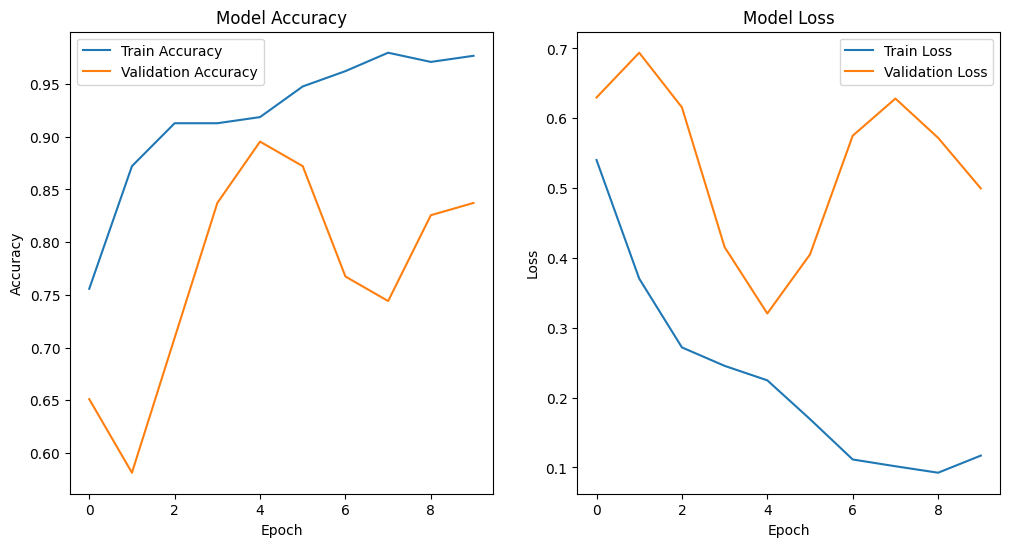

In [1]:
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Image dimensions
image_width, image_height = 224, 224
def load_images(paths):
    images = []
    for path in paths:
        image = cv2.imread(path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_width, image_height))
        images.append(image)
    return np.array(images)
# Load and preprocess images (assuming you have the 'load_images' function defined)
black_images_paths = glob('black/*')
normal_images_paths = glob('normal/*')
black_images = load_images(black_images_paths)
normal_images = load_images(normal_images_paths)

images = np.vstack((black_images, normal_images)) / 255.0
labels = np.array([1] * len(black_images) + [0] * len(normal_images))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Load VGG16 pre-trained base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_width, image_height, 3)))

# Freeze the layers of VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of VGG16 base
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {scores[0]}')
print(f'Test accuracy: {scores[1]}')

# Plot training and validation curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('modle_2.h5')  # Save the model
